In [1]:
import os
import numpy as np
import librosa
import scipy
import math
import pickle
import gammatone
import librosa.display
import matplotlib.pyplot as plt
import gammatone.gtgram
import six

MFCCS

In [2]:
def load_sound_mfccs(file_paths, n_mfcc):

    X,sr = librosa.load(file_paths, sr=11025, res_type='kaiser_fast')

    mfccs = librosa.feature.mfcc(y=X,sr=sr,n_mfcc=n_mfcc)
    
#    mfccs=np.mean(librosa.feature.mfcc(y=X,sr=sr,n_mfcc=40).T,axis=0)                                 
    return mfccs


In [3]:
Mfcc = load_sound_mfccs('D:\Thesis\Collated\examples\chimp2.wav', 40)

In [4]:
Mfcc.shape

(40, 230)

In [5]:
def mel_spec(file_paths, n_mels):

    X,sr = librosa.load(file_paths, sr=11025, res_type='kaiser_fast')
    melspec = librosa.feature.melspectrogram(y=X, sr=sr, n_mels=n_mels,fmax=5500)
                               
    return melspec

In [6]:
Ms = mel_spec('D:\Thesis\Collated\examples\chimp2.wav', 40)

In [7]:
Ms.shape
#Mel features 10-128 can be used in increments of 4 to check feature and model performance

(40, 230)

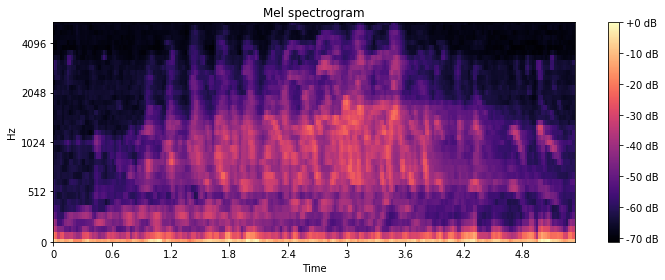

In [8]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(Ms,ref=np.max),y_axis='mel', fmax=5500,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [9]:
def gammatone_spec(file_paths, n_channels):

    X,sr = librosa.load(file_paths, sr=11025, res_type='kaiser_fast')
    gammaspec = gammatone.gtgram.gtgram(wave = X, fs = sr, window_time = 0.025, hop_time = 0.010, channels = n_channels, f_min = 20)             
                
    return gammaspec


#gammatone.gtgram.gtgram(wave, fs, window_time, hop_time, channels, f_min)

In [10]:
# def melspectrogram(y=None, sr=22050, S=None, n_fft=2048, hop_length=512,
#                    power=2.0, **kwargs):
#     S, n_fft = _spectrogram(y=y, S=S, n_fft=n_fft, hop_length=hop_length,
#                             power=power)

#     # Build a Mel filter
#     mel_basis = filters.mel(sr, n_fft, **kwargs)

#     return np.dot(mel_basis, S)

In [11]:
Gs = gammatone_spec('D:\Thesis\Collated\examples\chimp2.wav',64)

In [12]:
Gs.shape

(64, 1066)

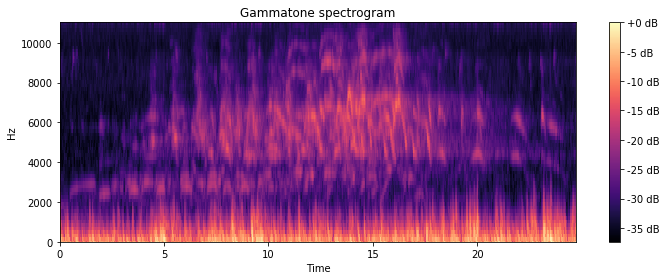

In [13]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(Gs,ref=np.max),y_axis='linear', fmax=5500,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Gammatone spectrogram')
plt.tight_layout()

In [14]:
def power_to_db(S, ref=1.0, amin=1e-10, top_db=80.0):
    
    """Convert a power spectrogram (amplitude squared) to decibel (dB) units

    This computes the scaling ``10 * log10(S / ref)`` in a numerically
    stable way.

    Parameters
    ----------
    S : np.ndarray
        input power

    ref : scalar or callable
        If scalar, the amplitude `abs(S)` is scaled relative to `ref`:
        `10 * log10(S / ref)`.
        Zeros in the output correspond to positions where `S == ref`.

        If callable, the reference value is computed as `ref(S)`.

    amin : float > 0 [scalar]
        minimum threshold for `abs(S)` and `ref`

    top_db : float >= 0 [scalar]
        threshold the output at `top_db` below the peak:
        ``max(10 * log10(S)) - top_db``

    Returns
    -------
    S_db   : np.ndarray
        ``S_db ~= 10 * log10(S) - 10 * log10(ref)``
    """   
    
    S = np.asarray(S)

    if amin <= 0:
        raise ParameterError('amin must be strictly positive')

    if np.issubdtype(S.dtype, np.complexfloating):
        warnings.warn('power_to_db was called on complex input so phase '
                      'information will be discarded. To suppress this warning, '
                      'call power_to_db(np.abs(D)**2) instead.')
        magnitude = np.abs(S)
    else:
        magnitude = S

    if six.callable(ref):
        # User supplied a function to calculate reference power
        ref_value = ref(magnitude)
    else:
        ref_value = np.abs(ref)

    log_spec = 10.0 * np.log10(np.maximum(amin, magnitude))
    log_spec -= 10.0 * np.log10(np.maximum(amin, ref_value))

    if top_db is not None:
        if top_db < 0:
            raise ParameterError('top_db must be non-negative')
        log_spec = np.maximum(log_spec, log_spec.max() - top_db)

    return log_spec



In [15]:
def load_sound_gtccs(file_paths, channels):

    X,sr = librosa.load(file_paths, sr=11025, res_type='kaiser_fast')

    gtccs = gtcc(y=X,sr=sr,n_gtcc = channels, window_time = 0.025, hop_time = 0.010 )
    
#    mfccs=np.mean(librosa.feature.mfcc(y=X,sr=sr,n_mfcc=40).T,axis=0)                                 
    return gtccs


In [16]:
# def gammaspectrogram(y, sr, channels, window_time, hop_time, 
#                    power=2.0, **kwargs):

# #    X,sr = librosa.load(file_paths, sr=11025, res_type='kaiser_fast')
#     gammaspec = gammatone.gtgram.gtgram(wave = y, fs = sr, channels = channels, window_time = 0.025, hop_time = 0.010,  f_min = 20)             
                
#     return gammaspec

In [17]:
def gammatone_spec(file_paths, n_channels):

    X,sr = librosa.load(file_paths, sr=11025, res_type='kaiser_fast')
    gammaspec = gammatone.gtgram.gtgram(wave = X, fs = sr, window_time = 0.025, hop_time = 0.010, channels = n_channels, f_min = 20)             
    S = power_to_db(gammaspec)     
    dct_type=2
    norm='ortho'
    gtccs = scipy.fftpack.dct(S, axis=0, type=dct_type, norm=norm)[:n_channels]
    return gtccs



In [18]:
def gtcc(y, sr, n_gtcc, **kwargs):

#    if S is None:
    S = power_to_db(gammatone_spec(y=y, sr=sr, **kwargs))
    dct_type=2
    norm='ortho'
    return scipy.fftpack.dct(S, axis=0, type=dct_type, norm=norm)[:n_gtcc]

In [19]:
Gtccs = gammatone_spec('D:\Thesis\Collated\examples\chimp2.wav', 32)

In [20]:
Gtccs.shape

(32, 1066)